
=== IT24102978 — Handle Missing Data ===
Shape BEFORE: (7422037, 21)


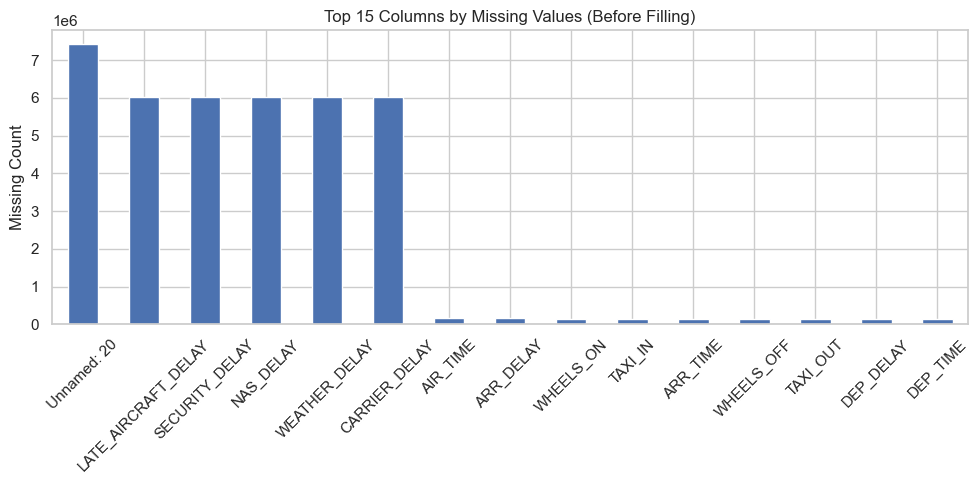

Missing AFTER (top 10):
FL_DATE              0
OP_UNIQUE_CARRIER    0
SECURITY_DELAY       0
NAS_DELAY            0
WEATHER_DELAY        0
CARRIER_DELAY        0
DISTANCE             0
AIR_TIME             0
ARR_DELAY            0
ARR_TIME             0
dtype: int64
Shape AFTER missing-data: (7422037, 20)


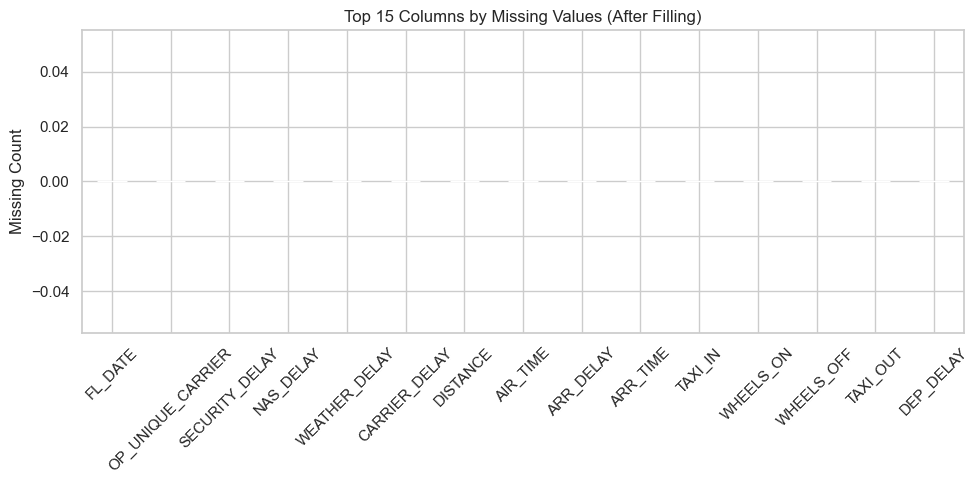

Saved -> C:\Users\it24102978\Desktop\AiML\output\after_missing.csv


In [1]:
# Group Pipeline — Airline Delay Analysis (Preprocessing & EDA)


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Try to import sklearn; if unavailable, scaling/PCA are skipped.
try:
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    _HAS_SKLEARN = True
except Exception:
    _HAS_SKLEARN = False
    print("Note: scikit-learn not found. Scaling and PCA will be skipped.")

# -----------------------------
# Paths (change if needed)
# -----------------------------
RAW_PATH = "C:\\Users\\it24102978\\Desktop\\AiML\\2019.csv"
OUT_DIR = "C:\\Users\\it24102978\\Desktop\\AiML\\output"
os.makedirs(OUT_DIR, exist_ok=True)

MAX_ROWS_FOR_SCALING = 300_000
ONEHOT_PREFIXES = ("CARRIER_", "ORIGIN_", "DEST_")

# ==============================================================
# IT24102978 — Handle Missing Data
# ==============================================================
print("\n=== IT24102978 — Handle Missing Data ===")
df = pd.read_csv(RAW_PATH)
print("Shape BEFORE:", df.shape)

# Plot missing values before filling
plt.figure(figsize=(10, 5))
df.isna().sum().sort_values(ascending=False).head(15).plot(kind="bar")
plt.title("Top 15 Columns by Missing Values (Before Filling)")
plt.ylabel("Missing Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "missing_values_before.png"))
plt.show()
plt.close()

# Drop fully empty columns
df = df.dropna(axis=1, how="all")

# Parse date
if "FL_DATE" in df.columns:
    df["FL_DATE"] = pd.to_datetime(df["FL_DATE"], errors="coerce")

# Known delay-cause NaNs -> 0
cause_cols = ["CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]
present_cause = [c for c in cause_cols if c in df.columns]
if present_cause:
    df[present_cause] = df[present_cause].fillna(0)

# Impute numeric/categorical
num_cols = df.select_dtypes(include="number").columns
cat_cols = df.select_dtypes(include="object").columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median(numeric_only=True))
for c in cat_cols:
    if df[c].isna().any():
        m = df[c].mode(dropna=True)
        if not m.empty:
            df[c] = df[c].fillna(m.iloc[0])

print("Missing AFTER (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))
print("Shape AFTER missing-data:", df.shape)

# Plot missing values after filling
plt.figure(figsize=(10, 5))
df.isna().sum().sort_values(ascending=False).head(15).plot(kind="bar", color="green")
plt.title("Top 15 Columns by Missing Values (After Filling)")
plt.ylabel("Missing Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "missing_values_after.png"))
plt.show()
plt.close()

df.to_csv(os.path.join(OUT_DIR, "after_missing.csv"), index=False)
print("Saved ->", os.path.join(OUT_DIR, "after_missing.csv"))



=== IT24102834 — Outlier Removal (IQR * 3 on DEP_DELAY/ARR_DELAY) ===


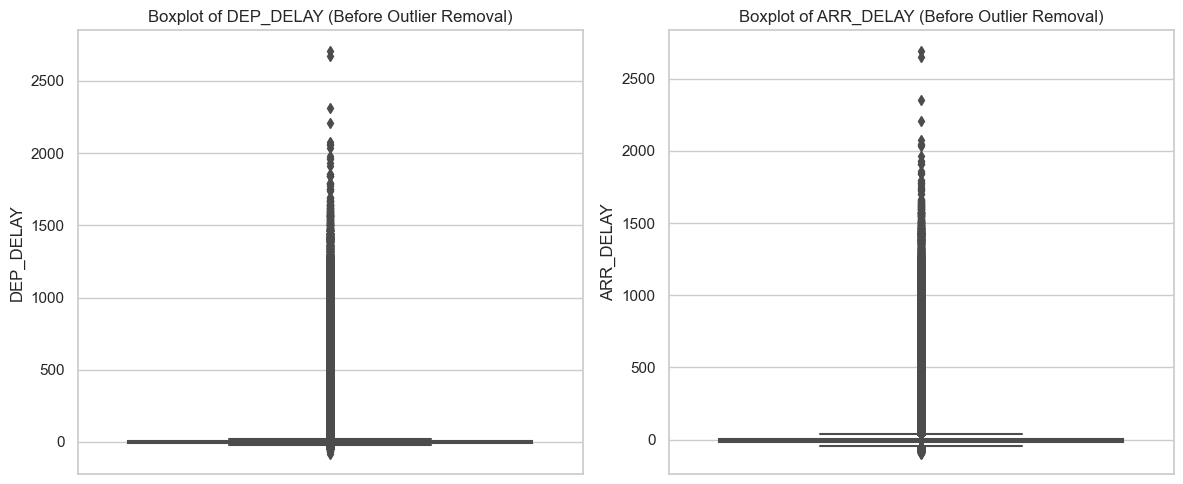

DEP_DELAY: removed 719539 outliers (k=3.0)
ARR_DELAY: removed 46035 outliers (k=3.0)
Shape AFTER outlier removal: (6656463, 20)


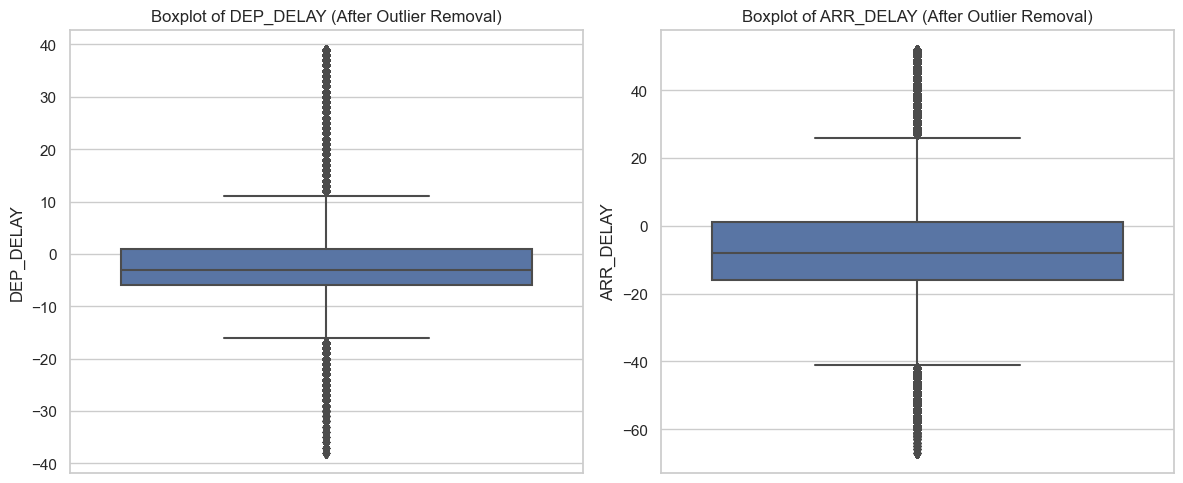

Saved -> C:\Users\it24102978\Desktop\AiML\output\after_outliers.csv


In [2]:
# ==============================================================
# IT24102834 — Outlier Removal
# ==============================================================
print("\n=== IT24102834 — Outlier Removal (IQR * 3 on DEP_DELAY/ARR_DELAY) ===")

df_original = pd.read_csv(os.path.join(OUT_DIR, "after_missing.csv"))

plt.figure(figsize=(12, 5))
for i, col in enumerate(["DEP_DELAY", "ARR_DELAY"]):
    if col in df_original.columns:
        plt.subplot(1, 2, i+1)
        sns.boxplot(y=df_original[col])
        plt.title(f"Boxplot of {col} (Before Outlier Removal)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "boxplot_before_outliers.png"))
plt.show()
plt.close()

def remove_outliers_iqr(data, col, k=3.0):
    s = data[col].dropna()
    if s.empty:
        return data
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0:
        return data
    lower, upper = q1 - k*iqr, q3 + k*iqr
    before = len(data)
    data = data[(data[col].isna()) | ((data[col] >= lower) & (data[col] <= upper))].copy()
    print(f"{col}: removed {before - len(data)} outliers (k={k})")
    return data

for col in ["DEP_DELAY", "ARR_DELAY"]:
    if col in df.columns:
        df = remove_outliers_iqr(df, col, k=3.0)

print("Shape AFTER outlier removal:", df.shape)

plt.figure(figsize=(12, 5))
for i, col in enumerate(["DEP_DELAY", "ARR_DELAY"]):
    if col in df.columns:
        plt.subplot(1, 2, i+1)
        sns.boxplot(y=df[col])
        plt.title(f"Boxplot of {col} (After Outlier Removal)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "boxplot_after_outliers.png"))
plt.show()
plt.close()

df.to_csv(os.path.join(OUT_DIR, "after_outliers.csv"), index=False)
print("Saved ->", os.path.join(OUT_DIR, "after_outliers.csv"))



=== IT24102889 — Encode Categorical Variables ===


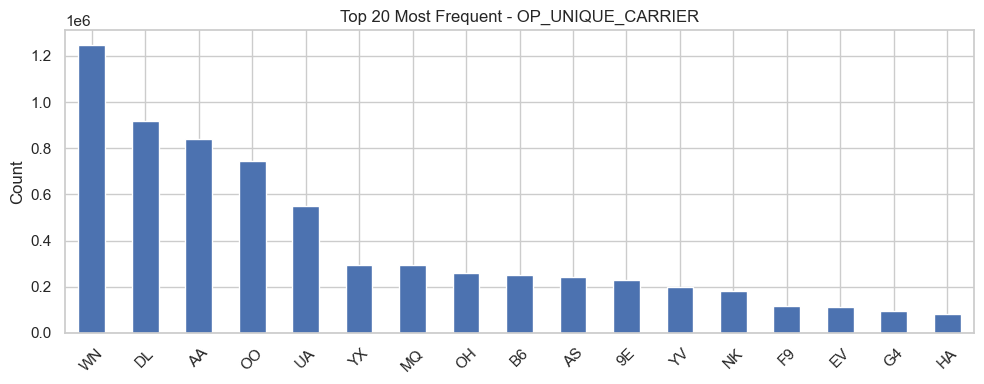

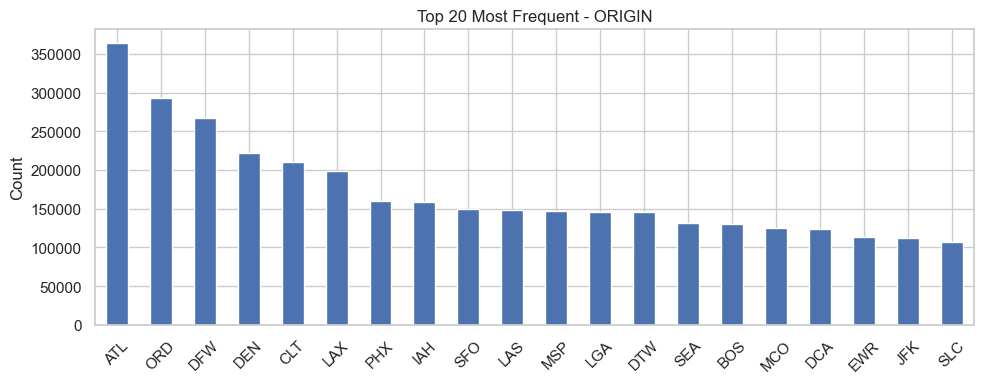

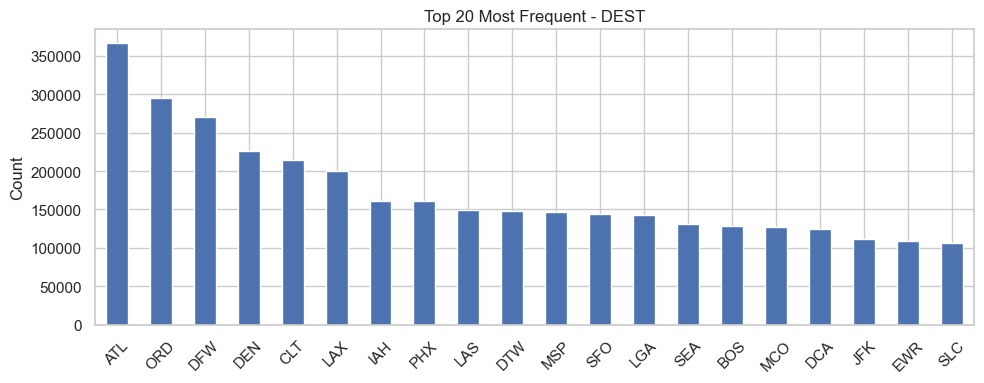

Shape AFTER encoding: (6656463, 98)
Saved -> C:\Users\it24102978\Desktop\AiML\output\after_encoding.csv


In [3]:
# ==============================================================
# IT24102889 — Encode Categorical Variables
# ==============================================================
print("\n=== IT24102889 — Encode Categorical Variables ===")

for col in ["OP_UNIQUE_CARRIER", "ORIGIN", "DEST"]:
    if col in df.columns:
        plt.figure(figsize=(10, 4))
        df[col].value_counts().head(20).plot(kind="bar")
        plt.title(f"Top 20 Most Frequent - {col}")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"{col}_top20.png"))
        plt.show()
        plt.close()

if "FL_DATE" in df.columns:
    df["YEAR"] = df["FL_DATE"].dt.year
    df["MONTH"] = df["FL_DATE"].dt.month
    df["DAY_OF_WEEK"] = df["FL_DATE"].dt.dayofweek
    df = df.drop(columns=["FL_DATE"])

TOP_K_AIRPORTS = 30
for col in ["ORIGIN", "DEST"]:
    if col in df.columns:
        top = df[col].value_counts().head(TOP_K_AIRPORTS).index
        df[col] = df[col].where(df[col].isin(top), "OTHER")

cols_to_encode = [c for c in ["OP_UNIQUE_CARRIER","ORIGIN","DEST"] if c in df.columns]
if cols_to_encode:
    df = pd.get_dummies(df, columns=cols_to_encode, dtype=int)

print("Shape AFTER encoding:", df.shape)
df.to_csv(os.path.join(OUT_DIR, "after_encoding.csv"), index=False)
print("Saved ->", os.path.join(OUT_DIR, "after_encoding.csv"))

In [4]:
# ==============================================================
# IT24102942 — Feature Engineering
# ==============================================================
print("\n=== IT24102942 — Feature Engineering ===")

feature_cols = ["IS_DELAYED_ARR", "IS_DELAYED_DEP", "IS_WEEKEND", "TOTAL_DELAY_CAUSES"]
for col in feature_cols:
    if col in df.columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col], bins=30, kde=False)
        plt.title(f"Distribution of {col}")
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"feature_{col}.png"))
        plt.show()
        plt.close()

if "ARR_DELAY" in df.columns:
    df["IS_DELAYED_ARR"] = (df["ARR_DELAY"] > 0).astype(int)
if "DEP_DELAY" in df.columns:
    df["IS_DELAYED_DEP"] = (df["DEP_DELAY"] > 0).astype(int)
if "DAY_OF_WEEK" in df.columns:
    df["IS_WEEKEND"] = df["DAY_OF_WEEK"].isin([5, 6]).astype(int)
present_cause = [c for c in cause_cols if c in df.columns]
if present_cause:
    df["TOTAL_DELAY_CAUSES"] = df[present_cause].sum(axis=1)

def to_hour(val):
    try:
        iv = int(val)
        return iv // 100
    except Exception:
        return np.nan

for src, out in [("CRS_DEP_TIME","CRS_DEP_HOUR"), ("CRS_ARR_TIME","CRS_ARR_HOUR")]:
    if src in df.columns:
        df[out] = df[src].apply(to_hour)

for col in ["CRS_DEP_HOUR", "CRS_ARR_HOUR"]:
    if col in df.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(x=col, data=df)
        plt.title(f"{col} Distribution (Hour of Day)")
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"{col}_distribution.png"))
        plt.show()
        plt.close()

print("Shape AFTER feature engineering:", df.shape)
df.to_csv(os.path.join(OUT_DIR, "after_features.csv"), index=False)
print("Saved ->", os.path.join(OUT_DIR, "after_features.csv"))



=== IT24102942 — Feature Engineering ===
Shape AFTER feature engineering: (6656463, 102)
Saved -> C:\Users\it24102978\Desktop\AiML\output\after_features.csv



=== IT24102856 — Normalization / Scaling (memory-safe) ===
Sampling 300,000 rows for scaling from 6,656,463.
Scaled SAMPLE shape: (300000, 39)
Saved -> C:\Users\it24102978\Desktop\AiML\output\scaled_features_SAMPLE.csv


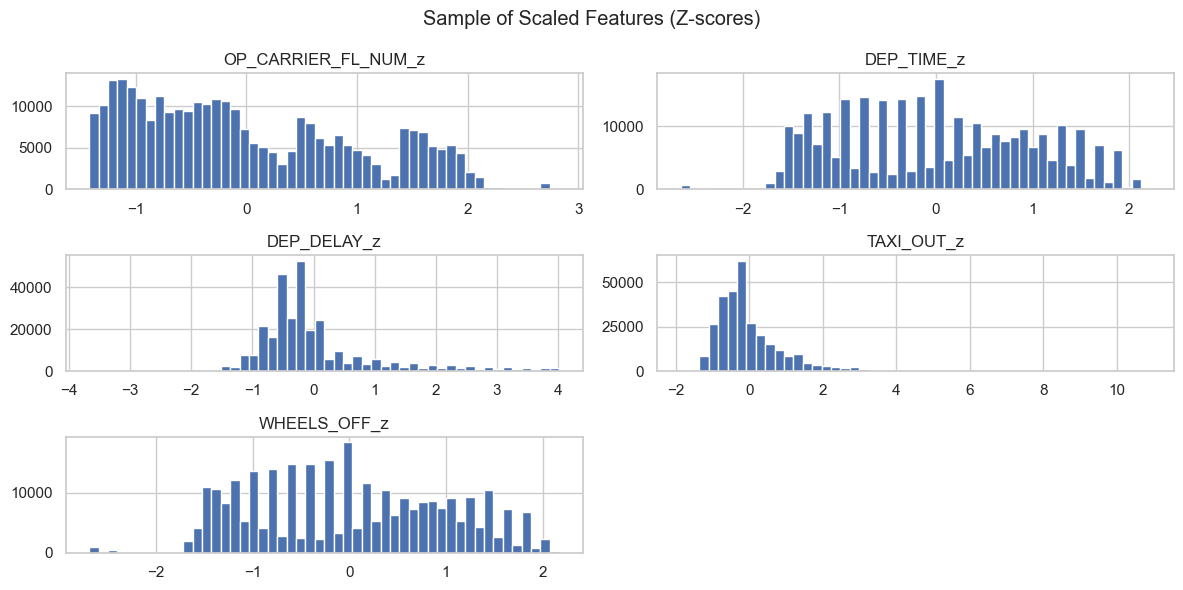

In [5]:
# ==============================================================
# IT24102856 — Normalization / Scaling
# ==============================================================
print("\n=== IT24102856 — Normalization / Scaling (memory-safe) ===")
X_scaled = None
if _HAS_SKLEARN:
    numeric_cols = df.select_dtypes(include="number").columns.tolist()
    scale_cols = [c for c in numeric_cols if not any(c.startswith(p) for p in ONEHOT_PREFIXES)]

    if (MAX_ROWS_FOR_SCALING is not None) and (len(df) > MAX_ROWS_FOR_SCALING):
        work_idx = df.sample(MAX_ROWS_FOR_SCALING, random_state=42).index
        print(f"Sampling {len(work_idx):,} rows for scaling from {len(df):,}.")
    else:
        work_idx = df.index

    work_X = df.loc[work_idx, scale_cols].fillna(0)
    try:
        work_X = work_X.astype("float32")
    except Exception:
        pass

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(work_X.values)
    scaled_sample = pd.DataFrame(X_scaled, columns=[f"{c}_z" for c in scale_cols], index=work_idx)
    scaled_sample.to_csv(os.path.join(OUT_DIR, "scaled_features_SAMPLE.csv"))
    print("Scaled SAMPLE shape:", scaled_sample.shape)
    print("Saved ->", os.path.join(OUT_DIR, "scaled_features_SAMPLE.csv"))
else:
    print("Skipped: scikit-learn not installed.")

if _HAS_SKLEARN and X_scaled is not None:
    scaled_cols = scaled_sample.columns[:5]
    scaled_sample[scaled_cols].hist(figsize=(12, 6), bins=50)
    plt.suptitle("Sample of Scaled Features (Z-scores)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "scaled_features_hist.png"))
    plt.show()
    plt.close()


=== IT24102979 — Dimensionality Reduction (PCA on sample) ===
PCA sample shape: (300000, 2)
Explained variance ratio: [0.11395883 0.08437334]
Saved -> C:\Users\it24102978\Desktop\AiML\output\pca_components_SAMPLE.csv


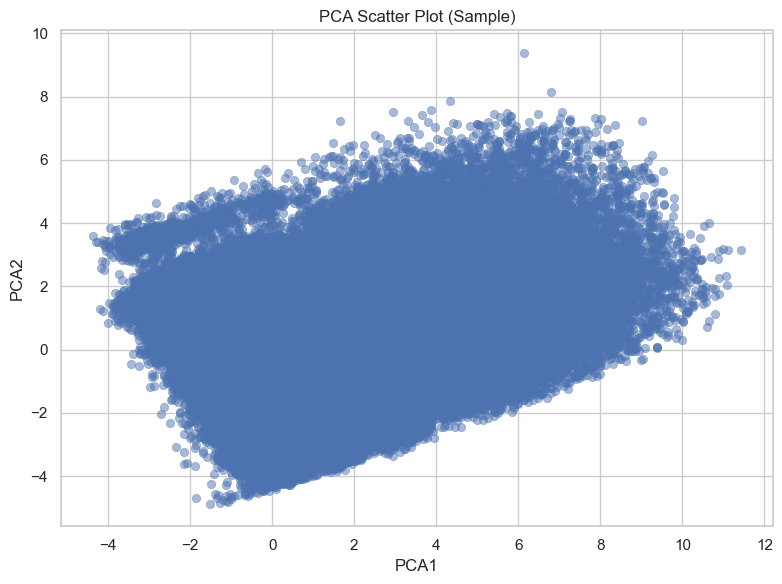


Final dataframe shape: (6656463, 104)
Saved final dataset -> C:\Users\it24102978\Desktop\AiML\output\final_processed_with_pca.csv


In [6]:
# ==============================================================
# IT24102979 — Dimensionality Reduction (PCA)
# ==============================================================
print("\n=== IT24102979 — Dimensionality Reduction (PCA on sample) ===")
if _HAS_SKLEARN and (X_scaled is not None):
    pca = PCA(n_components=2, random_state=42)
    comps = pca.fit_transform(X_scaled)
    pca_df = pd.DataFrame({"PCA1": comps[:, 0], "PCA2": comps[:, 1]}, index=work_idx)

    df.loc[work_idx, "PCA1"] = pca_df["PCA1"]
    df.loc[work_idx, "PCA2"] = pca_df["PCA2"]

    pca_df.to_csv(os.path.join(OUT_DIR, "pca_components_SAMPLE.csv"))
    print("PCA sample shape:", pca_df.shape)
    print("Explained variance ratio:", pca.explained_variance_ratio_)
    print("Saved ->", os.path.join(OUT_DIR, "pca_components_SAMPLE.csv"))

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PCA1", y="PCA2", data=pca_df, alpha=0.5, edgecolor=None)
    plt.title("PCA Scatter Plot (Sample)")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "pca_scatter.png"))
    plt.show()
    plt.close()
else:
    print("Skipped PCA: no scaled sample available or scikit-learn missing.")

print("\nFinal dataframe shape:", df.shape)
final_out = os.path.join(OUT_DIR, "final_processed_with_pca.csv")
df.to_csv(final_out, index=False)
print("Saved final dataset ->", final_out)
